# Demonstration of the Renewable Resource and Power Data Tool to the RTS-GMLC System

In [1]:
import logging
import os
cwd = os.getcwd()
import subprocess

import numpy as np
import pandas as pds

import sys
#sys.path.append('/Users/mrossol/Documents/Smart_DS/R2PD')
import R2PD
import time

import matplotlib.pyplot as plt
from mpl_toolkits.basemap import Basemap as Basemap
%matplotlib inline

logging.basicConfig()

def print_cli_call_and_output(cmds):
    print(subprocess.list2cmdline(cmds) + "\n")
    try:
        stdout = subprocess.check_output(cmds, stderr=subprocess.STDOUT)
    except subprocess.CalledProcessError as e:
        stdout = e.output
    print(stdout.decode('utf-8'))
    
rts_dir = os.path.join(cwd, 'rts_new_genmix_1')

[RTS Power Resource Data](#Power-Data-for-RTS-GMLC) | [R2PD Command Line Interface](#R2PD-Command-Line-Interface)

## Power Data for RTS-GMLC

### RTS Nodes

In [2]:
nodes = pds.read_csv(os.path.join(rts_dir,'nodes.csv'))
nodes = nodes[['node_id','latitude','longitude']]

nodes.head()

,node_id,latitude,longitude
0,101,33.396103,-113.835642
1,102,33.357678,-113.825933
2,103,33.536833,-114.670399
3,104,33.812304,-113.825419
4,105,33.659560,-113.999023


### RTS Generators

In [3]:
path = os.path.join(rts_dir, 'solar_one-axis-tracking', 'generators.csv')
PV_gen = pds.read_csv(path)

path = os.path.join(rts_dir, 'solar_rooftop', 'generators.csv')
RTPV_gen = pds.read_csv(path)

path = os.path.join(rts_dir, 'wind', 'generators.csv')
wind_gen = pds.read_csv(path)

wind_gen

,node_id,capacity (MW)
0,122,1000.0
1,303,847.0
2,309,148.3
3,317,1417.7


### Initialize connection to repositories

In [4]:
config_path = '/Users/mrossol/Documents/Smart_DS/beta_config.ini'

repo = R2PD.datastore.Peregrine.connect(config_path)

total_size, wind_size, solar_size = repo._local_cache.cache_size
max_size = repo._local_cache._size
print('''Local Cache Initialized: \n
Maximum size = {m} GB\n
Current size = {t} GB\n
\t Cached wind data = {w} GB \n
\t Cached solar data = {s} GB
'''.format(m=max_size, t=total_size, w=wind_size, s=solar_size))

repo._local_cache.cache_summary

Local Cache Initialized: 

Maximum size = 5.0 GB

Current size = 0 GB

	 Cached wind data = 0 GB 

	 Cached solar data = 0 GB



,fcst,fcst-prob,irradiance,met,power,sites
wind,0.0,0.0,NaN,0.0,0.0,0.0
solar,0.0,0.0,0.0,0.0,0.0,0.0


### Get resource for  RTS Renewable Nodes

In [5]:
wind_nodes_df = pds.merge(nodes, wind_gen, on='node_id', how='inner')
PV_nodes_df = pds.merge(nodes, PV_gen, on='node_id', how='inner')
RTPV_nodes_df = pds.merge(nodes, RTPV_gen, on='node_id', how='inner')
met_nodes_df = pds.concat([wind_nodes_df, PV_nodes_df, RTPV_nodes_df])[['node_id', 'latitude', 'longitude']]

In [6]:
NodeClass = R2PD.powerdata.WindMetNode
node_list = [NodeClass(*tuple(node_info)) for _, node_info in met_nodes_df.iterrows()]
met_nodes = R2PD.NodeCollection.factory(node_list)

met_nodes, _ = R2PD.queue.get_resource_data(met_nodes, repo)
repo._local_cache.cache_summary

,fcst,fcst-prob,irradiance,met,power,sites
wind,0.0,0.0,NaN,21.0,0.0,21.0
solar,0.0,0.0,0.0,0.0,0.0,0.0


/anaconda/lib/python3.6/site-packages/mpl_toolkits/basemap/__init__.py:3296: MatplotlibDeprecationWarning: The ishold function was deprecated in version 2.0.
  b = ax.ishold()
/anaconda/lib/python3.6/site-packages/mpl_toolkits/basemap/__init__.py:3305: MatplotlibDeprecationWarning: axes.hold is deprecated.
    See the API Changes document (http://matplotlib.org/api/api_changes.html)
    for more details.
  ax.hold(b)
/anaconda/lib/python3.6/site-packages/mpl_toolkits/basemap/__init__.py:3222: MatplotlibDeprecationWarning: The ishold function was deprecated in version 2.0.
  b = ax.ishold()
/anaconda/lib/python3.6/site-packages/mpl_toolkits/basemap/__init__.py:3231: MatplotlibDeprecationWarning: axes.hold is deprecated.
    See the API Changes document (http://matplotlib.org/api/api_changes.html)
    for more details.
  ax.hold(b)


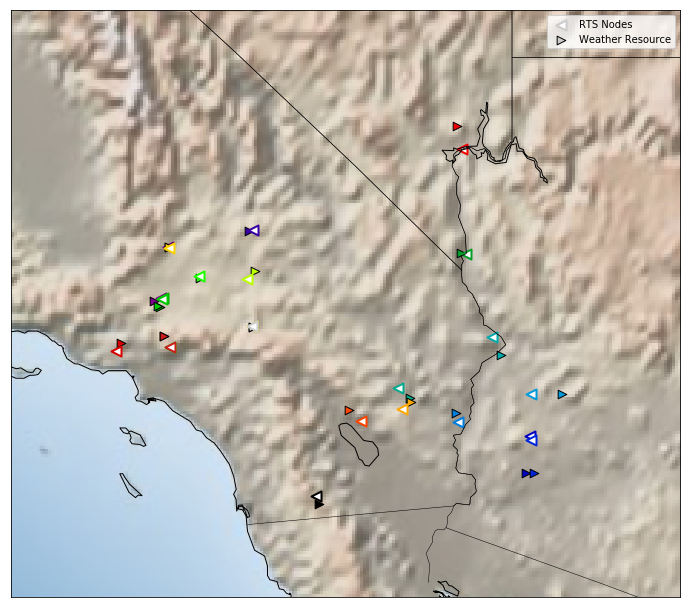

In [7]:
total_nodes = len(met_nodes)

buffersize = 1
color=iter(plt.cm.nipy_spectral(np.linspace(0,1, total_nodes)))
plt.figure(figsize=(12,12))
m = Basemap(
        projection='merc',
        llcrnrlon=min(nodes['longitude']-buffersize),
        llcrnrlat=min(nodes['latitude']-buffersize),
        urcrnrlon=max(nodes['longitude']+buffersize),
        urcrnrlat=max(nodes['latitude']+buffersize),
        lat_ts=0,
        resolution='i',
        suppress_ticks=True)


m.drawcountries()
m.drawstates()
m.drawcoastlines()
m.shadedrelief()
    
for node in met_nodes.nodes:
    c = next(color)
    re_long, re_lat = m(node._resource.longitude, node._resource.latitude)
    met_re = m.scatter(re_long, re_lat, 75, marker='>', facecolors=c, edgecolors='k', linewidth=1)
    
    node_long, node_lat = m(node.longitude, node.latitude)
    met = m.scatter(node_long, node_lat, 100, marker='<', facecolors='w', edgecolors=c, linewidth=2)

plt.legend([met, met_re],
           ['RTS Nodes', 'Weather Resource'])
plt.show()
plt.close()

In [8]:
NodeClass = R2PD.powerdata.SolarGeneratorNode
node_list = [NodeClass(*tuple(node_info)) for _, node_info in PV_nodes_df.iterrows()]
PV_nodes = R2PD.NodeCollection.factory(node_list)

PV_nodes, _ = R2PD.queue.get_resource_data(PV_nodes, repo)
repo._local_cache.cache_summary

,fcst,fcst-prob,irradiance,met,power,sites
wind,0.0,0.0,NaN,21.0,0.0,21.0
solar,0.0,0.0,0.0,0.0,1138.0,1138.0


/anaconda/lib/python3.6/site-packages/mpl_toolkits/basemap/__init__.py:3296: MatplotlibDeprecationWarning: The ishold function was deprecated in version 2.0.
  b = ax.ishold()
/anaconda/lib/python3.6/site-packages/mpl_toolkits/basemap/__init__.py:3305: MatplotlibDeprecationWarning: axes.hold is deprecated.
    See the API Changes document (http://matplotlib.org/api/api_changes.html)
    for more details.
  ax.hold(b)
/anaconda/lib/python3.6/site-packages/mpl_toolkits/basemap/__init__.py:3222: MatplotlibDeprecationWarning: The ishold function was deprecated in version 2.0.
  b = ax.ishold()
/anaconda/lib/python3.6/site-packages/mpl_toolkits/basemap/__init__.py:3231: MatplotlibDeprecationWarning: axes.hold is deprecated.
    See the API Changes document (http://matplotlib.org/api/api_changes.html)
    for more details.
  ax.hold(b)


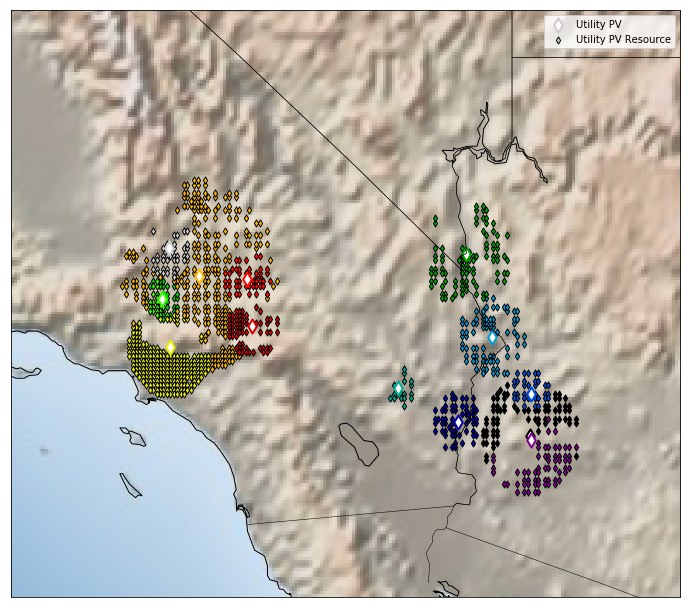

In [9]:
total_nodes = len(PV_nodes)

buffersize = 1
color=iter(plt.cm.nipy_spectral(np.linspace(0,1, total_nodes)))
plt.figure(figsize=(12,12))
m = Basemap(
        projection='merc',
        llcrnrlon=min(nodes['longitude']-buffersize),
        llcrnrlat=min(nodes['latitude']-buffersize),
        urcrnrlon=max(nodes['longitude']+buffersize),
        urcrnrlat=max(nodes['latitude']+buffersize),
        lat_ts=0,
        resolution='i',
        suppress_ticks=True)


m.drawcountries()
m.drawstates()
m.drawcoastlines()
m.shadedrelief()
    
for node in PV_nodes.nodes:
    c = next(color)
    resource_loc = node._resource.locations
    re_long, re_lat = m(resource_loc[:, 1], resource_loc[:, 0])
    PV_re = m.scatter(re_long, re_lat, 25, marker='d', facecolors=c, edgecolors='k', linewidth=1)
    
    node_long, node_lat = m(node.longitude, node.latitude)
    PV = m.scatter(node_long, node_lat, 100, marker='d', facecolors='w', edgecolors=c, linewidth=2)

plt.legend([PV, PV_re],
           ['Utility PV', 'Utility PV Resource'])
plt.show()
plt.close()

In [10]:
NodeClass = R2PD.powerdata.SolarGeneratorNode
node_list = [NodeClass(*tuple(node_info)) for _, node_info in RTPV_nodes_df.iterrows()]
RTPV_nodes = R2PD.NodeCollection.factory(node_list)

RTPV_nodes, _ = R2PD.queue.get_resource_data(RTPV_nodes, repo)
repo._local_cache.cache_summary

,fcst,fcst-prob,irradiance,met,power,sites
wind,0.0,0.0,NaN,21.0,0.0,21.0
solar,0.0,0.0,0.0,0.0,1200.0,1200.0


/anaconda/lib/python3.6/site-packages/mpl_toolkits/basemap/__init__.py:3296: MatplotlibDeprecationWarning: The ishold function was deprecated in version 2.0.
  b = ax.ishold()
/anaconda/lib/python3.6/site-packages/mpl_toolkits/basemap/__init__.py:3305: MatplotlibDeprecationWarning: axes.hold is deprecated.
    See the API Changes document (http://matplotlib.org/api/api_changes.html)
    for more details.
  ax.hold(b)
/anaconda/lib/python3.6/site-packages/mpl_toolkits/basemap/__init__.py:3222: MatplotlibDeprecationWarning: The ishold function was deprecated in version 2.0.
  b = ax.ishold()
/anaconda/lib/python3.6/site-packages/mpl_toolkits/basemap/__init__.py:3231: MatplotlibDeprecationWarning: axes.hold is deprecated.
    See the API Changes document (http://matplotlib.org/api/api_changes.html)
    for more details.
  ax.hold(b)


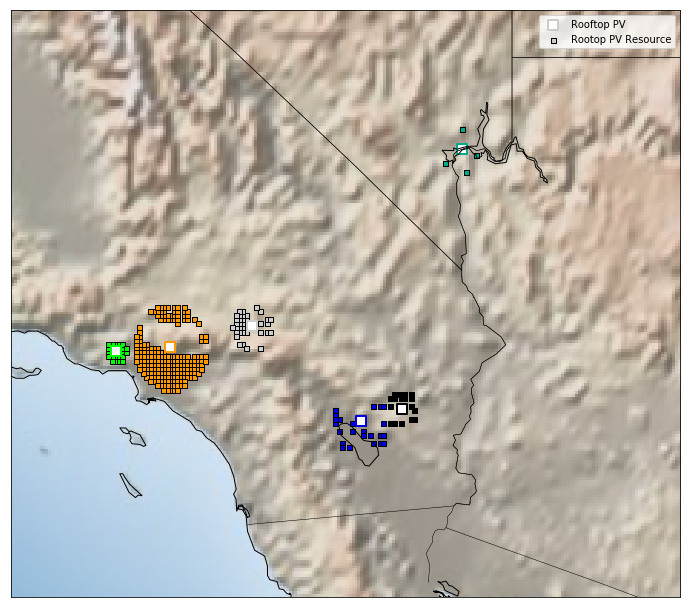

In [11]:
total_nodes = len(RTPV_nodes)

buffersize = 1
color=iter(plt.cm.nipy_spectral(np.linspace(0,1, total_nodes)))
plt.figure(figsize=(12,12))
m = Basemap(
        projection='merc',
        llcrnrlon=min(nodes['longitude']-buffersize),
        llcrnrlat=min(nodes['latitude']-buffersize),
        urcrnrlon=max(nodes['longitude']+buffersize),
        urcrnrlat=max(nodes['latitude']+buffersize),
        lat_ts=0,
        resolution='i',
        suppress_ticks=True)


m.drawcountries()
m.drawstates()
m.drawcoastlines()
m.shadedrelief()

for node in RTPV_nodes.nodes:
    c = next(color)
    resource_loc = node._resource.locations
    re_long, re_lat = m(resource_loc[:, 1], resource_loc[:, 0])
    RTPV_re = m.scatter(re_long, re_lat, 25, marker='s', facecolors=c, edgecolors='k', linewidth=1)
    
    node_long, node_lat = m(node.longitude, node.latitude)
    RTPV = m.scatter(node_long, node_lat, 100, marker='s', facecolors='w', edgecolors=c, linewidth=2)
    
plt.legend([RTPV, RTPV_re],
           ['Rooftop PV', 'Rootop PV Resource'])
plt.show()
plt.close()

In [12]:
NodeClass = R2PD.powerdata.WindGeneratorNode
node_list = [NodeClass(*tuple(node_info)) for _, node_info in wind_nodes_df.iterrows()]
wind_nodes = R2PD.NodeCollection.factory(node_list)

wind_nodes, _ = R2PD.queue.get_resource_data(wind_nodes, repo, forecasts=True)
repo._local_cache.cache_summary

,fcst,fcst-prob,irradiance,met,power,sites
wind,282.0,0.0,NaN,21.0,282.0,297.0
solar,0.0,0.0,0.0,0.0,1200.0,1200.0


/anaconda/lib/python3.6/site-packages/mpl_toolkits/basemap/__init__.py:3296: MatplotlibDeprecationWarning: The ishold function was deprecated in version 2.0.
  b = ax.ishold()
/anaconda/lib/python3.6/site-packages/mpl_toolkits/basemap/__init__.py:3305: MatplotlibDeprecationWarning: axes.hold is deprecated.
    See the API Changes document (http://matplotlib.org/api/api_changes.html)
    for more details.
  ax.hold(b)
/anaconda/lib/python3.6/site-packages/mpl_toolkits/basemap/__init__.py:3222: MatplotlibDeprecationWarning: The ishold function was deprecated in version 2.0.
  b = ax.ishold()
/anaconda/lib/python3.6/site-packages/mpl_toolkits/basemap/__init__.py:3231: MatplotlibDeprecationWarning: axes.hold is deprecated.
    See the API Changes document (http://matplotlib.org/api/api_changes.html)
    for more details.
  ax.hold(b)


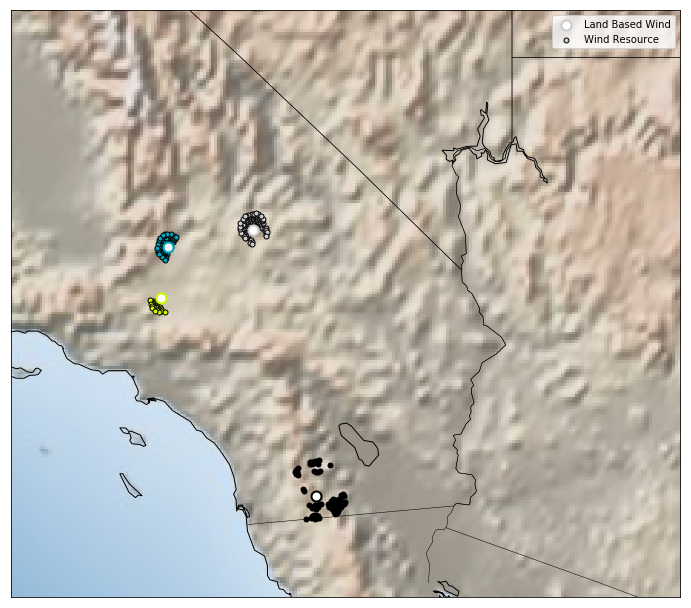

In [13]:
total_nodes = len(wind_nodes)

buffersize = 1
color=iter(plt.cm.nipy_spectral(np.linspace(0,1, total_nodes)))
plt.figure(figsize=(12,12))
m = Basemap(
        projection='merc',
        llcrnrlon=min(nodes['longitude']-buffersize),
        llcrnrlat=min(nodes['latitude']-buffersize),
        urcrnrlon=max(nodes['longitude']+buffersize),
        urcrnrlat=max(nodes['latitude']+buffersize),
        lat_ts=0,
        resolution='i',
        suppress_ticks=True)


m.drawcountries()
m.drawstates()
m.drawcoastlines()
m.shadedrelief()
    
for node in wind_nodes.nodes:
    c = next(color)
    resource_loc = node._resource.locations
    re_long, re_lat = m(resource_loc[:, 1], resource_loc[:, 0])
    wind_re = m.scatter(re_long, re_lat, 25, marker='o', facecolors=c, edgecolors='k', linewidth=1)
    
    node_long, node_lat = m(node.longitude, node.latitude)
    wind = m.scatter(node_long, node_lat, 100, marker='o', facecolors='w', edgecolors=c, linewidth=2)

plt.legend([wind, wind_re],
           ['Land Based Wind', 'Wind Resource'])
plt.show()
plt.close()

### Wind Forecast and Power

In [14]:
node = wind_nodes[122]
node.get_power(None)

node.get_forecasts(None)

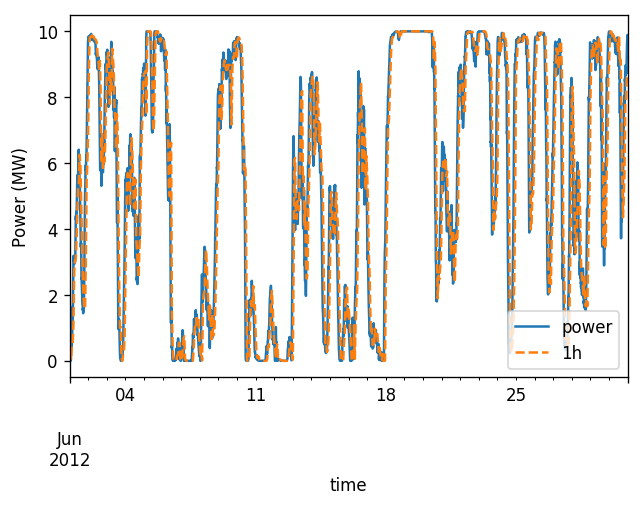

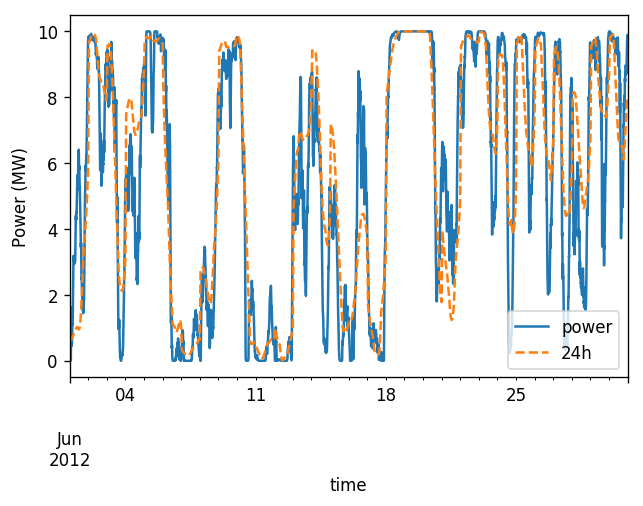

In [15]:
year = 2012
month = 6

power = node.power
power = power.loc[np.logical_and(power.index.year == 2012, power.index.month == month)]
fcst = node.fcst
fcst = fcst.loc[np.logical_and(fcst.index.year == 2012, fcst.index.month == month)]

fig = plt.figure(figsize=((6, 4)), dpi=120)
axis = fig.add_subplot(111)
power.plot(ax=axis)
fcst[['1h']].plot(ax=axis, linestyle='--')
axis.set_ylabel('Power (MW)')
plt.show()
plt.close()

fig = plt.figure(figsize=((6, 4)), dpi=120)
axis = fig.add_subplot(111)
power.plot(ax=axis)
fcst[['24h']].plot(ax=axis, linestyle='--')
axis.set_ylabel('Power (MW)')
plt.show()
plt.close()

## R2PD Command Line Interface

In [2]:
print("CLI path is:\n    {}".format(R2PD.cli_path))

CLI path is:
    /Users/mrossol/Documents/Smart_DS/R2PD/bin/rdt.py


### Help

In [3]:
print_cli_call_and_output(['python', R2PD.cli_path, '-h'])

python /Users/mrossol/Documents/Smart_DS/R2PD/bin/rdt.py -h

usage: rdt.py [-h] [-e {DRPower,Peregrine}] [-ds DS_CONFIG] [-d]
              {actual-power,forecast-power,weather} ...

Get wind, solar, or weather data for power system modeling.

positional arguments:
  {actual-power,forecast-power,weather}

optional arguments:
  -h, --help            show this help message and exit
  -e {DRPower,Peregrine}, --external-datastore {DRPower,Peregrine}
                        Name of the external datastore to query for resource
                        data not yet cached locally.
  -ds DS_CONFIG, --ds-config DS_CONFIG
                        'Path to datastore configuration file.
  -d, --debug           Option to output debug information.



### Get Weather Resource

In [4]:
print_cli_call_and_output(['python', R2PD.cli_path, 'weather', '-h'])

python /Users/mrossol/Documents/Smart_DS/R2PD/bin/rdt.py weather -h

usage: rdt.py weather [-h] [-tz {UTC}] [-r TEMPORAL_RESOLUTION] [-f FORMATTER]
                      outdir nodes temporal_extent temporal_extent
                      {instantaneous,average_next,average_prev,average_midpt,integrated_next,integrated_prev,integrated_midpt}
                      {wind,solar} ...

positional arguments:
  outdir                Directory for output data.
  nodes                 Path to csv file describing nodes, or list of tuples
                        describing nodes. Each tuple or each row of the csv
                        file should contain (node_id, latitude, longitude).
  temporal_extent       Start and end datetimes for output data.
  {instantaneous,average_next,average_prev,average_midpt,integrated_next,integrated_prev,integrated_midpt}
                        Interpretation that will be assumed for output
                        timeseries values. Can affect exactly which raw d

In [5]:
config_path = '/Users/mrossol/Documents/Smart_DS/beta_config.ini'
rts_dir = os.path.join(cwd, 'rts_new_genmix_1')
nodes = os.path.join(rts_dir, 'wind/nodes.csv')
out_dir = os.path.join(rts_dir, 'R2PD_Resource')
if not os.path.exists(out_dir):
    os.makedirs(out_dir)
    
extent = ['2012-01-01', '2013-01-01']
p_interp = 'instantaneous'
dataset = 'wind'

print_cli_call_and_output(['python', R2PD.cli_path, '-e', 'Peregrine', '-ds', config_path,
                           'weather', out_dir, nodes, *extent, p_interp, '-r', 'h', dataset])

python /Users/mrossol/Documents/Smart_DS/R2PD/bin/rdt.py -e Peregrine -ds /Users/mrossol/Documents/Smart_DS/beta_config.ini weather /Users/mrossol/Documents/Smart_DS/demos/rts_new_genmix_1/R2PD_Resource /Users/mrossol/Documents/Smart_DS/demos/rts_new_genmix_1/wind/nodes.csv 2012-01-01 2013-01-01 instantaneous -r h wind

Local Cache Initialized: 

    Maximum size = 5.00 GB

    Current size = 2.55 GB

    	 Cached wind data = 1.66 GB 

    	 Cached solar data = 0.89 GB
    
Finding resource for 73 WindMetNodes
Identifying resource sites and downloading if necessary
73 resource sites extracted in 3.9870 minutes
Saving processed resource data to /Users/mrossol/Documents/Smart_DS/demos/rts_new_genmix_1/R2PD_Resource



### Get Power Resource

In [6]:
print_cli_call_and_output(['python', R2PD.cli_path, 'actual-power', '-h'])

python /Users/mrossol/Documents/Smart_DS/R2PD/bin/rdt.py actual-power -h

usage: rdt.py actual-power [-h] [-tz {UTC}] [-r TEMPORAL_RESOLUTION]
                           [-f FORMATTER]
                           outdir nodes temporal_extent temporal_extent
                           {instantaneous,average_next,average_prev,average_midpt,integrated_next,integrated_prev,integrated_midpt}
                           {wind,solar} ...

positional arguments:
  outdir                Directory for output data.
  nodes                 Path to csv file describing nodes, or list of tuples
                        describing nodes. Each tuple or each row of the csv
                        file should contain (node_id, latitude, longitude).
  temporal_extent       Start and end datetimes for output data.
  {instantaneous,average_next,average_prev,average_midpt,integrated_next,integrated_prev,integrated_midpt}
                        Interpretation that will be assumed for output
                     

In [7]:
config_path = '/Users/mrossol/Documents/Smart_DS/beta_config.ini'
rts_dir = os.path.join(cwd, 'rts_new_genmix_1')
nodes = os.path.join(rts_dir, 'wind/nodes.csv')
generators = os.path.join(rts_dir, 'wind/generators.csv')
out_dir = os.path.join(rts_dir, 'R2PD_Resource')
if not os.path.exists(out_dir):
    os.makedirs(out_dir)
    
extent = ['2012-01-01', '2013-01-01']
p_interp = 'instantaneous'
dataset = 'wind'

print_cli_call_and_output(['python', R2PD.cli_path, '-e', 'Peregrine', '-ds', config_path,
                           'actual-power', out_dir, nodes, *extent, p_interp, '-r', 'h', dataset, generators])

python /Users/mrossol/Documents/Smart_DS/R2PD/bin/rdt.py -e Peregrine -ds /Users/mrossol/Documents/Smart_DS/beta_config.ini actual-power /Users/mrossol/Documents/Smart_DS/demos/rts_new_genmix_1/R2PD_Resource /Users/mrossol/Documents/Smart_DS/demos/rts_new_genmix_1/wind/nodes.csv 2012-01-01 2013-01-01 instantaneous -r h wind /Users/mrossol/Documents/Smart_DS/demos/rts_new_genmix_1/wind/generators.csv

Local Cache Initialized: 

    Maximum size = 5.00 GB

    Current size = 3.12 GB

    	 Cached wind data = 2.23 GB 

    	 Cached solar data = 0.89 GB
    
Finding resource for 4 WindGeneratorNodes
Identifying resource sites and downloading if necessary
282 resource sites extracted in 1.1601 minutes
Saving processed resource data to /Users/mrossol/Documents/Smart_DS/demos/rts_new_genmix_1/R2PD_Resource



### Timeseries of Resource

In [8]:
path = os.path.join(out_dir, 'wind_met_122.csv')
wind_met = pds.read_csv(path, index_col=0)
wind_met.index = pds.to_datetime(wind_met.index)

path = os.path.join(out_dir, 'wind_power_122.csv')
wind_power = pds.read_csv(path, index_col=0)
wind_power.index = pds.to_datetime(wind_power.index)

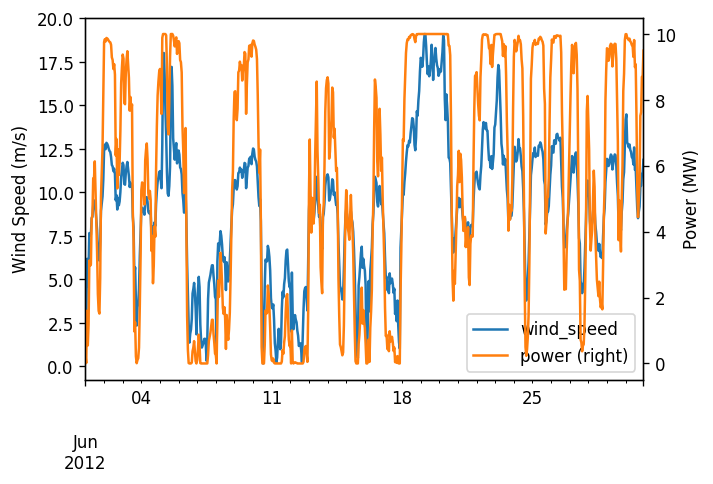

In [9]:
month = 6

met_to_plot = wind_met.loc[wind_met.index.month == month, ['wind_speed']]
power_to_plot = wind_power.loc[wind_power.index.month == month, ['power']]
to_plot = met_to_plot.join(power_to_plot)

fig = plt.figure(figsize=((6, 4)), dpi=120)
axis = fig.add_subplot(111)
ax = to_plot.plot(secondary_y=['power'], ax=axis)
ax.set_ylabel('Wind Speed (m/s)')
ax.right_ax.set_ylabel('Power (MW)')
plt.show()
plt.close()

### Data Retrieval TImes

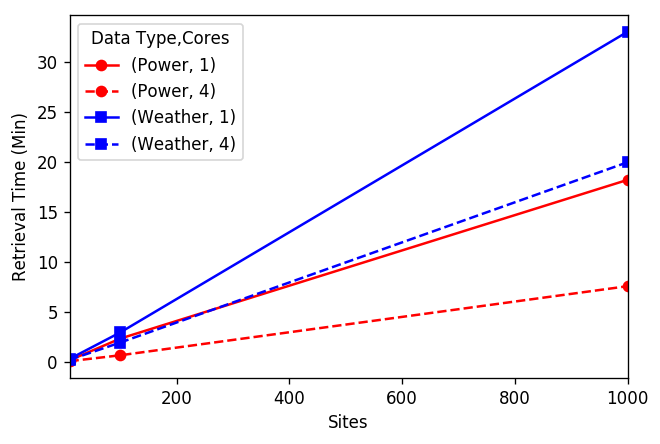

In [10]:
path = os.path.join(cwd, 'R2PD_Download_Times.csv')
down_times = pds.read_csv(path)
table = pds.pivot_table(down_times, values='Time',
                       index=['Data Type', 'Cores'],
                       columns=['Sites'])

fig = plt.figure(figsize=((6, 4)), dpi=120)
axis = fig.add_subplot(111)
table.T.plot(ax=axis,
             style=['ro-', 'ro--', 'bs-', 'bs--'],)
axis.set_ylabel('Retrieval Time (Min)')
plt.show()